# Riconoscimento delle Emozioni Facciali tramite Transfer Learning e Computer Vision


**Introduzione**

Il presente progetto si pone l'obiettivo di implementare un sistema per il riconoscimento delle emozioni facciali in tempo reale (Face Emotion Recognition), utilizzando un'architettura di deep learning basata su **TensorFlow** e le librerie **Python** e **OpenCV**. Il sistema finale è in grado di analizzare un flusso video da webcam, identificare i volti presenti e classificare l'emozione espressa tra sette categorie principali: rabbia, disgusto, paura, felicità, tristezza, sorpresa e neutralità.

**Metodologia: Transfer Learning**

La metodologia adottata è quella del **Transfer Learning**. Anziché addestrare un modello di rete neurale da zero, un processo che richiederebbe notevoli risorse computazionali e un vasto dataset, si è scelto di sfruttare i pesi di un modello pre-addestrato. Nello specifico, si è utilizzato un modello come **MobileNetV2**, già addestrato sul dataset **ImageNet** (contenente 1000 classi di oggetti comuni). Questa conoscenza pregressa viene "trasferita" al nostro problema specifico, modificando solo gli strati finali della rete per adattarla alla classificazione delle 7 emozioni facciali. Questo approccio permette di ottenere un'elevata accuratezza con tempi di addestramento significativamente ridotti.

**Dataset e Pre-elaborazione dei Dati**

Il dataset impiegato per l'addestramento e la validazione del modello è **FER2013 (Face Expression Recognition 2013)**, disponibile sulla piattaforma Kaggle. Questo dataset, pur essendo realistico e derivato da immagini reali, presenta diverse sfide come lo squilibrio tra le classi (es. poche immagini per 'disgusto'), variazioni intra-classe (immagini reali, disegni, cartoni), occlusioni e variazioni di contrasto. Per poter utilizzare il transfer learning, le immagini del dataset (originariamente 48x48 pixel) sono state pre-elaborate e ricampionate alla dimensione di input richiesta dal modello pre-addestrato (224x224 pixel).

**Strumenti e Implementazione**

L'implementazione è stata sviluppata in ambiente **Anaconda** utilizzando **Jupyter Notebook** come IDE. Le principali librerie impiegate includono:
- **TensorFlow**: per la costruzione e l'addestramento del modello di deep learning.
- **OpenCV**: per l'acquisizione del flusso video, il rilevamento del volto e la manipolazione delle immagini (es. sovrapposizione del testo e dei riquadri di delimitazione).
- **NumPy** e **Matplotlib**: per la gestione degli array numerici e la visualizzazione dei dati.

Il risultato finale è una demo funzionale che dimostra l'efficacia del transfer learning per applicazioni di visione artificiale complesse, anche in presenza di dataset impegnativi.

# Road Map dello sviluppo

L'implementazione del progetto sarà strutturata in 3 fasi principali, di cui presentiamo una *Road Map*

1.  **Fase 1: Preparazione dei Dati (Le operazioni iniziali)**
    *   **Scopo**: Rendere i nostri dati (le immagini del dataset FER2013) adatti ad essere elaborati dal modello.
    *   **Azioni**:
        *   **Caricamento e Ridimensionamento**: Leggiamo ogni immagine e la ridimensioniamo a `224x224` pixel. Questo è **obbligatorio** perché il modello MobileNetV2 è stato costruito per lavorare con questa specifica dimensione di input.
        *   **Creazione di `X` e `y`**: Separiamo i dati in `X` (gli array di pixel delle immagini, cioè l'input) e `y` (le etichette numeriche da 0 a 6, cioè l'output desiderato). Questa separazione è il formato standard richiesto da ogni framework di machine learning.
        *   **Mescolamento (`Shuffle`)**: Mescoliamo i dati per garantire che il modello apprenda in modo robusto, senza essere influenzato dall'ordine in cui le immagini sono state salvate.
        *   **Normalizzazione**: Rimoduliamo i valori dei pixel da `[0, 255]` a `[0, 1]`. Questo passaggio è cruciale per rendere l'addestramento della rete neurale più veloce e stabile.

2.  **Fase 2: Costruzione del Modello (Le celle che stiamo analizzando ora)**
    *   **Scopo**: Creare la nostra architettura finale combinando il modello pre-addestrato con i nostri strati di classificazione.
    *   **Azioni**:
        *   Caricare il "corpo" di MobileNetV2 ovvero i layers convoluzionali che sono già addestrati a riconoscere oggetti, senza la sua "testa" originale ovvero l'ultimo strato che è deputato non al riconoscimento ma alla classificazione degli oggetti.
        *   Costruire una nuova "testa" di classificazione con un output di 7 neuroni (uno per ogni emozione).
        *   Collegare la nuova testa al corpo del modello base.

3.  **Fase 3: Compilazione e Addestramento**
    *   **Scopo**: Definire le regole di apprendimento e avviare il processo di training.
    *   **Azioni**:
        *   **Compilare** il modello, definendo la funzione di perdita (come misurare l'errore) e l'ottimizzatore (come correggere l'errore).
        *   **Addestrare** il modello (`fit`) fornendogli i dati `X` e `y` preparati nella Fase 1.

Seguendo questo piano, arriveremo al nostro obiettivo finale: un modello specializzato e performante, ottenuto con una frazione del tempo e delle risorse che sarebbero state necessarie partendo da zero.

# Implementazione

## **Settaggi fondamentali (Fase 1)** 

Per prima cosa, è necessario effettuare gli import (previa installazione come indicato) delle seguenti librerie:

In [1]:
import tensorflow as tf ## pip install tensorflow-gpu
import cv2 ## pip install opencv-python
## pip install opencv-contrib-python fullpackage
import os
import matplotlib.pyplot as plt ## pip install matplotlib
import numpy as np ## pip install numpy

C:\Users\vitaa\anaconda3\envs\cv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


A questo punto va impostata la *Datadirectory* che conterrà i dataset che utilizzeremo per l'addestramento della Neural Network

In [2]:
# Definizione del percorso della directory con le immagini di training
Datadirectory = "../Computer_Vision/dataset/train/"

Vengono ora definte le 7 classi presenti nel training set che rappresentano le 7 tipologie di emozioni rilevabili. Per ognuna delle 7 tipologie di emozioni è presente una cartella apposita di immagini che la rappresentano; tali cartelle sono state rinominate con le cifre 0,1,2,3,4,5,6 e rappresentano le emozioni secondo questa conversione:
- **angry** = 0
- **disgust** = 1
- **fear** = 2
- **happy** = 3
- **neutral** = 4
- **sad** = 5
- **surprise** = 6

In [3]:
Classes = ["0","1","2","3","4","5","6"] #lista delle classi per il training

Fatto questo, vengono realizzate una lettura ed una stampa di prova dell'immagine, per assicurarci che la gestione delle immagini tramite cv2 stia funzionando in maniera corretta

In [4]:
# Lettura e stampa di un'immagine di test per accertare funzionamento degli import
image_path = Datadirectory + "0/Training_31705730.jpg"

img_array = cv2.imread(image_path)

# --- CONTROLLO ---
# Verifica se l'immagine è stata caricata correttamente
if img_array is None:
    print(f"Errore nel caricamento dell'immagine! Controlla il percorso: {image_path}")
else:
    print("Immagine caricata con successo!")
    print(f"Le dimensioni dell'immagine sono: {img_array.shape}")

Immagine caricata con successo!
Le dimensioni dell'immagine sono: (48, 48, 3)


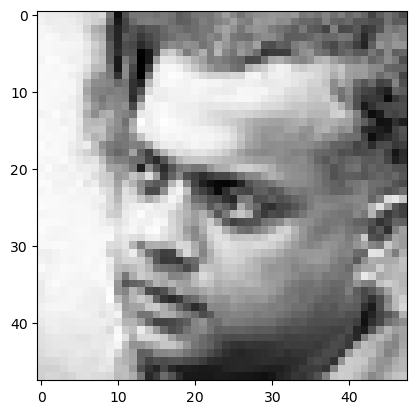

In [5]:
plt.imshow(img_array)

Se tutto è andato a buon fine (messaggio di success + stampa di un'immagine), possiamo procedere con il **prossimo test**. Scorriamo le 7 cartelle presenti nel training set e salviamo la prima immagine di ognuna di queste cartelle come matrice di pixel, poi stampiamo ogni immagine a video. Se tutto è andato come dovrebbe sarà stampata la prima immagine di ognuna delle 7 cartelle del training set

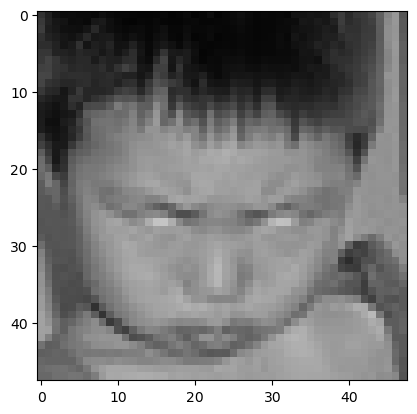

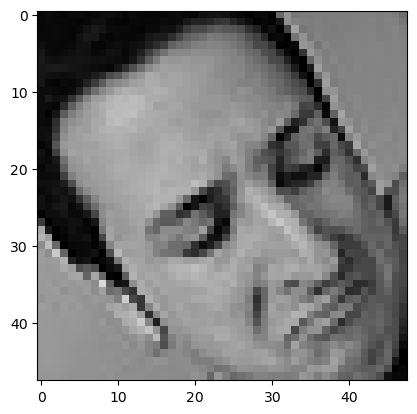

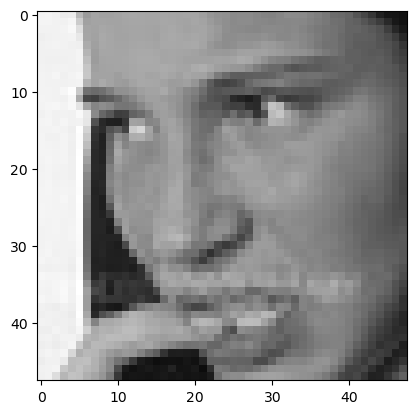

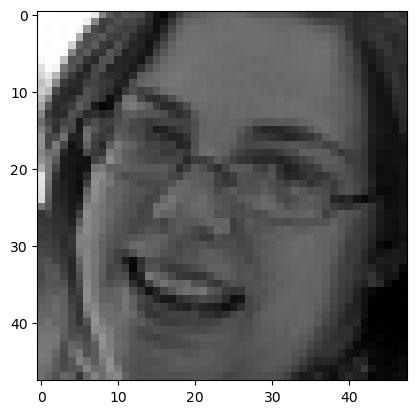

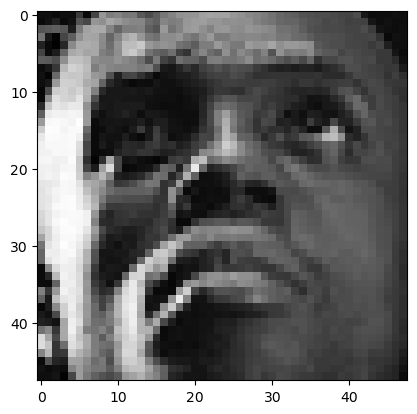

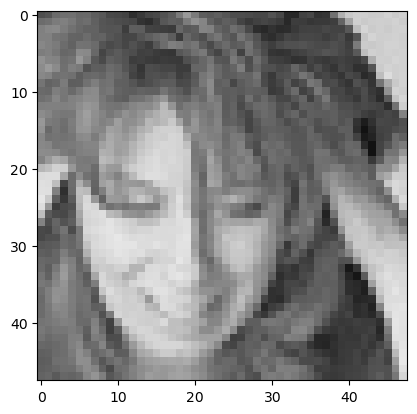

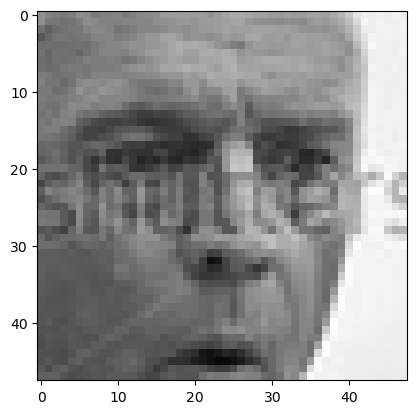

In [6]:
# Inizia un ciclo esterno per ogni categoria (da "0" a "6")
for category in Classes:
    
    # Costruisce il percorso completo alla cartella della categoria
    path = os.path.join(Datadirectory, category)
    
    # Inizia un ciclo interno per ogni immagine nella cartella
    for img in os.listdir(path):
        
        # Legge il file immagine e lo carica come un array di pixel
        img_array = cv2.imread(os.path.join(path,img))
        
        # Converte i colori e prepara l'immagine per la visualizzazione
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        
        # Mostra l'immagine
        plt.show()
        
        # Interrompe il ciclo interno dopo aver mostrato la prima immagine
        #della categoria in analisi
        break

## **Images resize (Fase 1)** 

### Perchè è necessario il resize

Il modello pre-addestrato che verrà utilizzato nel progetto è **MobileNetV2**; tale modello è stato addestrato su un dataset di circa 14 milioni di immagini chiamato **ImageNet**, largamente utilizzato nell'ambito della computer vision, il quale è composto di immagini della dimensione standard di 224px x 224px, è pertanto necessario effetture il resize delle immagini del dataset open source **FER2013** che hanno dimensione 48px x 48px.
Andiamo quindi a verificare che il resize funzioni correttamente applicandolo all'ultima immagine convertita durante la fase di *Settaggi fondamentali*

In [7]:
img_size = 224 ## ImageNet => 224 x 224

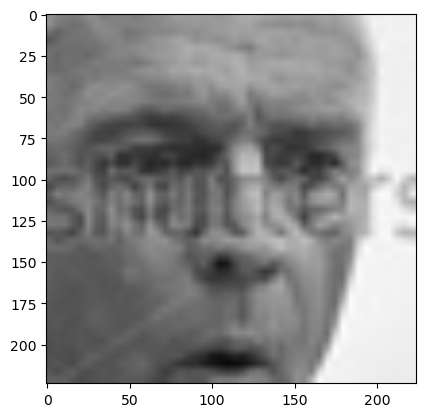

In [8]:
new_array = cv2.resize(img_array,(img_size,img_size))
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
new_array.shape #se l'output restituito è (224, 224, 3) il resize è andato a buon fine

(224, 224, 3)

### Script per il resize di tutte le immagini del training set a RunTime (sconsigliato)

Da un punto di vista **computazionale**, effettuare il resize di tutto il training set a Run Time risulta estremamente oneroso. Pertanto qui si propone lo script per poter effettuare il resize dinamicamente, ma nella restante parte del documento utilizzeremo una seconda versione del dataset di cui è stato effettuato il resize in maniera asincrona 

Definiamo un array *training_Data* ed inseriamo in esso le 7 categorie di immagini prese dal dataset open source resized alla dimensione 224px x 224px

In [10]:
"""
# Inizializza una lista vuota che conterrà i dati di addestramento.
# Ogni elemento della lista sarà a sua volta una lista contenente: [array_immagine_ridimensionata, etichetta_numerica_classe]
training_Data = []

# Definisce la funzione che si occuperà di creare il set di dati di addestramento.
def create_training_Data():
    # Itera attraverso ogni categoria (le cartelle da "0" a "6") definita nella lista 'Classes'.
    for category in Classes:
        # Crea il percorso completo per la cartella della categoria corrente (es. "dataset/train/0").
        path = os.path.join(Datadirectory, category)
        
        # Ottiene l'etichetta numerica (da 0 a 6) per la categoria corrente.
        # Ad esempio, per la cartella "0", class_num sarà 0; per la "1", sarà 1, e così via.
        class_num = Classes.index(category)
        
        # Itera su ogni file immagine presente nella cartella della categoria.
        for img in os.listdir(path):
            # Utilizza un blocco try-except per gestire eventuali errori (es. file immagine corrotto).
            # Se un'immagine non può essere letta o processata, l'errore viene ignorato e il ciclo continua.
            try:
                # Legge il file immagine e lo converte in un array di pixel NumPy.
                img_array = cv2.imread(os.path.join(path,img))
                
                # Ridimensiona l'immagine alle dimensioni richieste dal modello MobileNetV2 (224x224 pixel).
                new_array = cv2.resize(img_array,(img_size,img_size))
                
                # Aggiunge l'immagine ridimensionata e la sua etichetta numerica alla lista training_Data.
                training_Data.append([new_array,class_num])
            except Exception as e:
                # In caso di errore, non fa nulla ('pass') e procede con l'immagine successiva.
                pass
"""

'\n# Inizializza una lista vuota che conterrà i dati di addestramento.\n# Ogni elemento della lista sarà a sua volta una lista contenente: [array_immagine_ridimensionata, etichetta_numerica_classe]\ntraining_Data = []\n\n# Definisce la funzione che si occuperà di creare il set di dati di addestramento.\ndef create_training_Data():\n    # Itera attraverso ogni categoria (le cartelle da "0" a "6") definita nella lista \'Classes\'.\n    for category in Classes:\n        # Crea il percorso completo per la cartella della categoria corrente (es. "dataset/train/0").\n        path = os.path.join(Datadirectory, category)\n        \n        # Ottiene l\'etichetta numerica (da 0 a 6) per la categoria corrente.\n        # Ad esempio, per la cartella "0", class_num sarà 0; per la "1", sarà 1, e così via.\n        class_num = Classes.index(category)\n        \n        # Itera su ogni file immagine presente nella cartella della categoria.\n        for img in os.listdir(path):\n            # Utilizza 

In [11]:
#create_training_Data()

In [12]:
#print(len(training_Data))

### Inizializzazione Dataset con resize asincrono (versione utilizzata nel seguente documento)

Il Dataset che viene realmente utilizzato nel documento è il **FER2013**. Se ne utilizza però una versione resized alle dimensioni 224px x 224px (Il resize è stato realizzato in un secondo jupyter notebook presente nella cartella del progetto).

A questo punto quindi inizializziamo il dataset resized che useremo, caricandone tutte le immagini in memoria RAM (circa 4gb di RAM saranno occupati dal dataset)

In [13]:
# Definizione del percorso della directory con le immagini di training resized
resized_data_directory = "../Computer_Vision/dataset_resized/train/"

In [14]:
# Inizializza una lista vuota che conterrà i dati di addestramento.
# Ogni elemento sarà una lista [array_immagine, etichetta_numerica].
training_Data = []

# Definisce la funzione per caricare il set di dati di addestramento già processato.
def create_training_Data():
    # Itera attraverso ogni categoria (le cartelle da "0" a "6") definita nella lista 'Classes'.
    for category in Classes:
        # Crea il percorso completo per la cartella della categoria, usando la nuova directory dei dati ridimensionati.
        path = os.path.join(resized_data_directory, category)
        
        # Ottiene l'etichetta numerica (da 0 a 6) per la categoria corrente.
        class_num = Classes.index(category)
        
        # Itera su ogni file immagine presente nella cartella della categoria.
        for img in os.listdir(path):
            # Utilizza un blocco try-except per gestire eventuali errori di lettura del file.
            try:
                # Legge il file immagine (che è GIA' 224x224) e lo converte in un array di pixel NumPy.
                img_array = cv2.imread(os.path.join(path,img))
                
                # Aggiunge direttamente l'immagine letta e la sua etichetta numerica alla lista training_Data.
                # L'operazione di resize è stata rimossa perché non più necessaria.
                training_Data.append([img_array, class_num])
            except Exception as e:
                # In caso di errore, ignora il file e continua con il successivo.
                print(f"Errore durante la lettura di {img}: {e}")
                pass

In [15]:
create_training_Data()

In [16]:
print(len(training_Data))

28709


#### 1. Formato della Singola Immagine

Ogni singola immagine viene letta e convertita in un **array NumPy**.

*   **Dimensioni (Shape):** `(224, 224, 3)`
    *   `224`: Altezza dell'immagine in pixel.
    *   `224`: Larghezza dell'immagine in pixel.
    *   `3`: I canali di colore. OpenCV, per default, li legge nell'ordine **BGR** (Blu, Verde, Rosso).
*   **Tipo di Dati:** Ogni valore all'interno dell'array è un numero intero (`uint8`) che va da **0 a 255**, e rappresenta l'intensità di un canale di colore per un singolo pixel.

#### 2. Struttura Dati che Contiene Tutto (`training_Data`)

La struttura dati complessiva è una **lista Python** (`list`) chiamata `training_Data`.

Ogni elemento di questa lista è a sua volta un'altra **lista con due elementi**:
1.  **Indice 0:** L'array NumPy dell'immagine (nel formato 224x224x3 descritto sopra).
2.  **Indice 1:** L'etichetta (label) della classe, rappresentata da un **singolo numero intero** (da 0 a 6).

Visivamente, la struttura si presenta così:

```
training_Data = [
    # Elemento 0
    [ <array_immagine_1 (224x224x3)>,  <etichetta_1 (es. 3 per 'happy')> ],

    # Elemento 1
    [ <array_immagine_2 (224x224x3)>,  <etichetta_2 (es. 0 per 'angry')> ],

    # Elemento 2
    [ <array_immagine_3 (224x224x3)>,  <etichetta_3 (es. 5 per 'sad')>   ],
    
    ... e così via per tutte le 28.709 immagini.
]
```

## **Definizione delle features (Fase 1)**

### Random Shuffling dei Training Data

La prima cosa che va fatta prima della definizione delle features è il **random shuffling** dei dati presenti nella nostra *training_Data*:

Questo passaggio è fondamentale per l'addestramento. Evita che il modello impari seguendo un ordine specifico (ad esempio, vedendo prima tutte le immagini di "rabbia", poi tutte quelle di "felicità"). Mescolare i dati garantisce che ogni "lotto" (batch) di immagini che il modello analizza durante il training sia una rappresentazione bilanciata e casuale di tutte le emozioni, migliorando la sua capacità di generalizzare e non essere influenzato dall'ordine di presentazione.

In [17]:
import random
random.shuffle(training_Data)

### La Selezione delle Features nel Deep Learning

Nel machine learning tradizionale, la selezione delle features (o *feature engineering*) è un processo manuale e cruciale. L'esperto del dominio deve scegliere a priori quali caratteristiche dei dati sono più rilevanti per il compito di predizione. Ad esempio, per predire il prezzo di una casa, le features potrebbero essere la superficie, il numero di stanze e la distanza dal centro.

Nel deep learning, e in particolare nella computer vision, l'approccio è radicalmente diverso: le features non vengono scelte manualmente, ma **vengono apprese automaticamente dal modello** direttamente dai dati grezzi.


*   **Handcrafted Features (Fatte a mano):** In un approccio classico al riconoscimento facciale, un ingegnere potrebbe dover scrivere algoritmi per misurare specifiche caratteristiche del volto: la distanza tra gli occhi, la curvatura degli angoli della bocca, l'apertura delle palpebre. Questo processo è laborioso, richiede una profonda conoscenza del problema e potrebbe tralasciare features importanti ma non ovvie.

*   **Learned Features (Apprese dal modello):** Le Reti Neurali Convoluzionali (CNN) imparano una **gerarchia di features** in modo automatico.
    *   **Strati iniziali:** Imparano a riconoscere features di basso livello come bordi, angoli e gradienti di colore.
    *   **Strati intermedi:** Combinano queste features semplici per riconoscere forme più complesse come occhi, nasi e bocche.
    *   **Strati finali:** Combinano le parti del viso per identificare strutture facciali complete.

Il modello impara autonomamente quali di queste features, a ogni livello di astrazione, sono più discriminative per distinguere, ad esempio, un volto "felice" da uno "triste".

### Come viene implementata in questo progetto: Transfer Learning


In questo notebook, non estraiamo manualmente alcuna feature. Le nostre "features" sono semplicemente i dati grezzi delle immagini.

*   **`X` (Dati di Input):** Non è una lista di misurazioni facciali, ma l'insieme degli **array di pixel grezzi** che compongono le immagini (nel formato `224x224x3`).
*   **`y` (Etichette):** Sono le "risposte corrette" che il modello deve imparare a predire (i numeri da 0 a 6 che rappresentano le emozioni).

Sfruttiamo il **Transfer Learning** utilizzando il modello **MobileNetV2**, già pre-addestrato sul vasto dataset ImageNet. Questo significa che il modello è già un potentissimo **estrattore di features visive**: i suoi strati hanno già imparato a riconoscere la gerarchia di features (linee, forme, oggetti) da milioni di immagini.

Il nostro compito, quindi, non è insegnare al modello a "vedere", ma insegnargli a **mappare le features complesse che già sa estrarre** applicandole alle nostre 7 classi di emozioni. Le celle di codice seguenti preparano i dati in questo formato `X` e `y`, pronti per essere forniti al nostro modello pre-addestrato.

In [18]:
X = [] ## data / feature
y = [] ## label

for features,label in training_Data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3) ## converting it to 4 dimension


In [19]:
X.shape

(28709, 224, 224, 3)

### Normalizzazione delle features

La normalizzazione è un passaggio di pre-elaborazione fondamentale e quasi sempre necessario nell'addestramento delle reti neurali. Consiste nel riscalare i valori numerici delle nostre features in un intervallo standardizzato, senza distorcere le differenze nei loro intervalli di valori.

Nel nostro caso, le features sono i valori dei pixel delle immagini, che originariamente vanno da 0 (nero) a 255 (bianco puro). La normalizzazione trasforma questo intervallo in uno più piccolo, tipicamente **da 0 a 1**.

Questa operazione è cruciale per due motivi principali:

1.  **Migliora la Convergenza del Modello:** Le reti neurali apprendono più velocemente e in modo più stabile quando i dati di input sono su una scala simile e vicina allo zero. Valori di input molto grandi (come 255) possono rallentare il processo di apprendimento (discesa del gradiente) e, in alcuni casi, impedirgli di "convergere" verso una soluzione ottimale.

2.  **Stabilità Numerica:** Riducendo la scala dei valori, si evitano potenziali problemi di instabilità numerica durante i calcoli matematici che avvengono all'interno della rete, garantendo un addestramento più fluido.

L'**implementazione nel progetto** è molto semplice ed efficiente. Poiché sappiamo che il valore massimo di ogni pixel è 255 (nero) ed il valore minimo è 0 (bianco), possiamo normalizzare l'intero dataset di immagini (`X`) semplicemente dividendolo per questo valore.

Il codice seguente esegue questa operazione in modo vettorizzato su tutto l'array NumPy, convertendo l'intervallo di ogni pixel da `[0, 255]` a `[0.0, 1.0]`

In [20]:
# normalize the data
X = X/255.0; ## we are normalizing it

MemoryError: Unable to allocate 32.2 GiB for an array with shape (28709, 224, 224, 3) and data type float64

In [ ]:
Y = np.array(y)

In [ ]:
Y.shape

## **Deep Learning Model e applicazione del transfer learning (Fase 2)**

### Settings di base del modello MobileNetV2

Conclusa la fase di pre-elaborazione dei dati, entriamo ora nella **Fase 2** del nostro piano d'azione: la costruzione del modello di deep learning. In questa sezione, implementeremo la strategia di **Transfer Learning** descritta in precedenza.

Il primo passo consiste nel caricare il modello **MobileNetV2** così come viene fornito da TensorFlow, completo dei suoi pesi pre-addestrati sul dataset **ImageNet**. Questo ci fornisce una base convoluzionale molto potente, già esperta nell'estrazione di features visive complesse.

Successivamente, utilizzeremo il metodo `.summary()` per ispezionare l'architettura del modello. Questa analisi ci permetterà di confermare la dimensione di input richiesta (verificando la correttezza del nostro resize a 224x224) e, soprattutto, di identificare lo strato di classificazione finale (la "testa" del modello), che andremo a sostituire per adattare la rete al nostro compito specifico di riconoscimento delle 7 emozioni.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = tf.keras.applications.MobileNetV2()

In [ ]:
model.summary()

### Isolamento dei layer convoluzionali

Il nostro obiettivo è utilizzare MobileNetV2 come un estrattore di features. Per fare ciò, dobbiamo separare il "corpo" del modello (gli strati convoluzionali che hanno imparato a riconoscere le features visive) dalla sua "testa" (lo strato finale di classificazione per le 1000 classi di ImageNet).

Nelle celle seguenti, isoliamo il punto di ingresso (`input`) del modello e l'output del penultimo strato. Quest'ultimo rappresenta il vettore di features di alto livello che la rete ha estratto dall'immagine, ed è su questo che costruiremo la nostra classificazione personalizzata.

In [ ]:
base_input = model.layers[0].input ## input

In [ ]:
base_output = model.layers[-2].output ## output

### Costruzione del nuovo strato di classificazione personalizzato sulle nostre 7 classi

Una volta ottenute le features dalla base convoluzionale (*base_output*), dobbiamo aggiungere i nostri strati di classificazione. Questa nuova "testa" del modello sarà composta da strati `Dense` (fully-connected) che hanno il compito di apprendere come mappare le features visive estratte alle nostre 7 classi di emozioni.

L'architettura che implementiamo è la seguente:
1.  Uno strato `Dense` con 128 neuroni, seguito da una funzione di attivazione `ReLU`.
2.  Un secondo strato `Dense` con 64 neuroni, anch'esso seguito da `ReLU`.
3.  Lo strato di output finale: uno strato `Dense` con **7 neuroni** (uno per ogni emozione) e una funzione di attivazione **`softmax`**. La softmax è fondamentale in quanto converte l'output della rete in un vettore di probabilità, indicando la probabilità che l'immagine appartenga a ciascuna delle 7 classi.

In [ ]:
# Aggiunge un nuovo strato denso (fully-connected) dopo la base
final_output = layers.Dense(128)(base_output)
# Applica una funzione di attivazione non lineare (ReLU)
final_output = layers.Activation('relu')(final_output)
# Aggiunge un altro strato denso
final_output = layers.Dense(64)(final_output)
# Applica nuovamente ReLU
final_output = layers.Activation('relu')(final_output)
# Aggiunge lo strato di output finale per la classificazione
final_output = layers.Dense(7, activation='softmax')(final_output) ## Le nostre classi sono 7

### Creazione e Analisi del Nuovo Modello personalizzato

Utilizzando l'API Funzionale di Keras, assembliamo ora il nostro modello finale. Specifichiamo l'input della base (`base_input`) come input del nuovo modello e l'output della nostra testa personalizzata (`final_output`) come suo output.

Infine, stampiamo nuovamente il `.summary()` per verificare che l'architettura sia corretta: noteremo la base MobileNetV2 seguita dai nostri strati `Dense`, con lo strato finale che produce correttamente un output per 7 classi.

In [ ]:
new_model = keras.Model(inputs = base_input, outputs = final_output) 
#assemblaggio del nuovo modello (base convoluzionale originale, testa di classificazione personalizzata)

In [ ]:
new_model.summary()

## **Compilazione del Modello (Fase 3)**

### Compilazione del Modello

La compilazione è l'ultimo passo prima dell'addestramento e serve a configurare il processo di apprendimento del modello. In questa fase definiamo tre componenti essenziali:

1.  **`loss` (Funzione di Perdita):** Specifica come viene misurato l'errore del modello. Utilizziamo `"sparse_categorical_crossentropy"` perché è la funzione di perdita standard per problemi di classificazione multi-classe in cui le etichette sono fornite come numeri interi (es. 0, 1, 2...).
2.  **`optimizer` (Ottimizzatore):** È l'algoritmo che aggiorna i pesi della rete per minimizzare la funzione di perdita. `"adam"` è una scelta robusta ed efficiente che si adatta bene alla maggior parte dei problemi.
3.  **`metrics` (Metriche):** Sono i valori che vogliamo monitorare durante l'addestramento per valutare le performance del modello. Con `["accuracy"]`, chiediamo di calcolare la percentuale di predizioni corrette ad ogni epoca.

In [ ]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])